# Data Preprocessing and Loading

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# PyTorch version
print(torch.__version__)

1.12.0


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# CIFAR10 dataset
trainset = CIFAR10(root='./data', train=True, download=False, transform=transform)
testset = CIFAR10(root='./data', train=False, download=False, transform=transform)

# Select classes
selected_classes = [0, 1, 2, 3, 4, 6]
train_indices = [i for i, label in enumerate(trainset.targets) if label in selected_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in selected_classes]

trainset = Subset(trainset, train_indices)
testset = Subset(testset, test_indices)

In [22]:
label_map = {label: i for i, label in enumerate(selected_classes)}
label_map

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5}

In [23]:
# Change labels
for i in train_indices:
    trainset.dataset.targets[i] = label_map[trainset.dataset.targets[i]]
for i in test_indices:
    testset.dataset.targets[i] = label_map[testset.dataset.targets[i]]

In [24]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Data Visualization

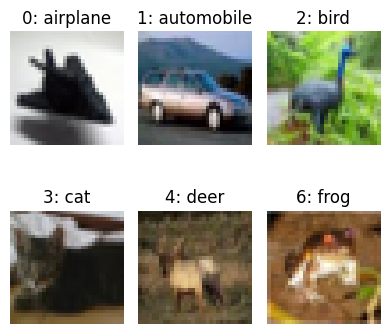

In [26]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = np.array(class_names)[selected_classes]

# Visualize one image of each class
fig, axs = plt.subplots(2, 3, figsize=(4, 4))
for i, ax in enumerate(axs.flat):
    # matching_images = [img for img, label in trainset if label == i]
    # img = random.choice(matching_images)  # too slow
    img = next(img for img, label in trainset if label == i)
    img = 0.5 * img + 0.5  # unnormalize
    img = img.numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'{selected_classes[i]}: {class_names[i]}')
    ax.axis('off')

plt.tight_layout()
plt.show()


# Custom CNN

In [27]:
# class CustomCNN(nn.Module):
#     def __init__(self):
#         super(CustomCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(64 * 8 * 8, 128)
#         self.fc2 = nn.Linear(128, 6)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 64 * 8 * 8)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x
    
    
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 6)  # 6 output classes
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        
        x = x.view(-1, 128 * 4 * 4)  # Flatten
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Training

In [ ]:
model = CustomCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(trainloader)
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')


Epoch [1/20], Loss: 1.0424
Epoch [2/20], Loss: 0.7668
Epoch [3/20], Loss: 0.6533
Epoch [4/20], Loss: 0.5819
Epoch [5/20], Loss: 0.5209
Epoch [6/20], Loss: 0.4686
Epoch [7/20], Loss: 0.4210
Epoch [8/20], Loss: 0.3761
Epoch [9/20], Loss: 0.3363
Epoch [10/20], Loss: 0.2997
Epoch [11/20], Loss: 0.2615
Epoch [12/20], Loss: 0.2372
Epoch [13/20], Loss: 0.2108
Epoch [14/20], Loss: 0.1823
Epoch [15/20], Loss: 0.1679
Epoch [16/20], Loss: 0.1543
Epoch [17/20], Loss: 0.1289
Epoch [18/20], Loss: 0.1242
Epoch [19/20], Loss: 0.1141
Epoch [20/20], Loss: 0.1028


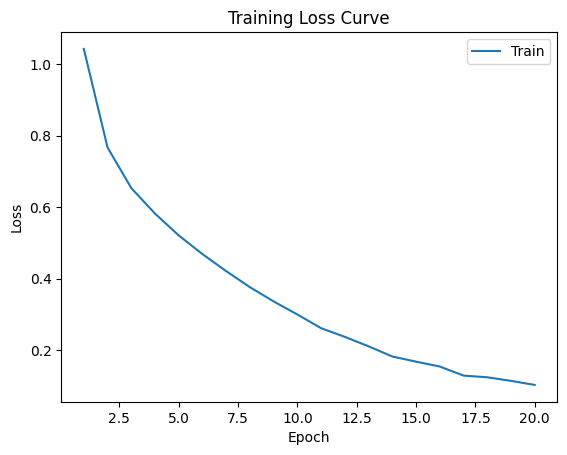

In [37]:
# Plot the training loss curve
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    
    # Calculate AUROC
    if len(set(all_labels)) == 2:  # Binary classification
        auroc = roc_auc_score(all_labels, [p[1] for p in all_probs])
    else:  # Multiclass classification
        auroc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    
    print(f'Accuracy: {acc:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, AUROC: {auroc:.4f}')
    return cm

# 评估模型
cm = evaluate(model, testloader)

Accuracy: 0.8260, Recall: 0.8260, Precision: 0.8378, F1 Score: 0.8278, AUROC: 0.9738


# Results Visulization

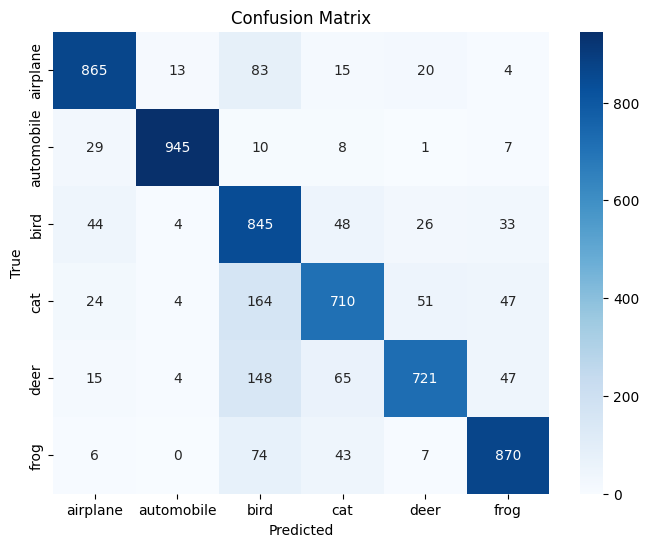

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
